In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append("D:\GitHub\pymrghost")
from mrfft import *
from nyquist_ghost_correction import *

In [2]:
epi_file = r"D:\data\ksp0401_X296Y88Passes50.mat"

In [3]:
import scipy.io
mat = scipy.io.loadmat(epi_file) # single-shot EPI in dims of (kx, ky, coil, slice)

In [4]:
ksp= mat['ksp'][:,:-4,:,:] # crop a few ref scan line 
ksp = fft2c(crop(ifft2c(ksp,axes=(0,1)), (128,84,16,48)),axes=(0,1))# remove readout oversampling
ksp.shape # kx, ky, coil, slice

(128, 84, 16, 48)

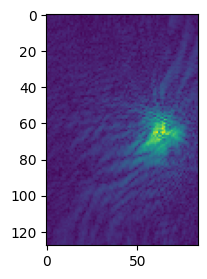

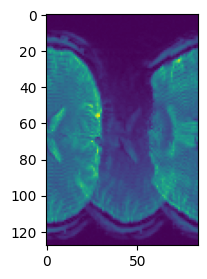

In [5]:
plt.figure(figsize=(3,3))
plt.imshow(np.abs(ksp[...,0,20])**0.5)
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(sos(ifft2c(ksp[...,20],(0,1)),2))
plt.show()

In [6]:
epi_kxkyzc_raw = np.moveaxis(ksp, 2, 3) # kx, ky, slice, coil
epi_kxkyzc_lpcCor, phasepara = oneDimLinearCorr_entropy(epi_kxkyzc_raw, nShot=1) # single-shot EPI

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:53<00:00,  1.12s/it]


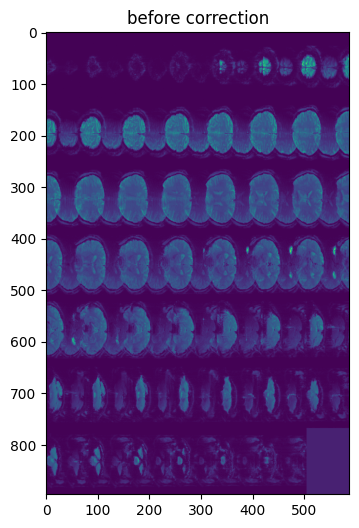

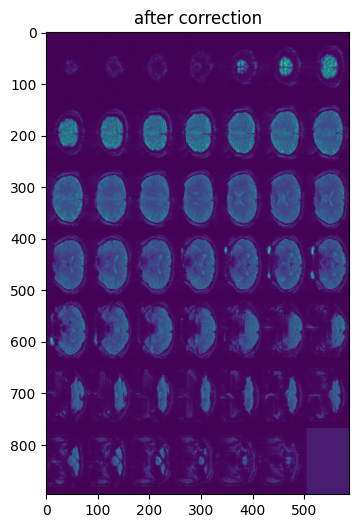

In [7]:
from skimage.util import montage
plt.figure(figsize=(6,6))
plt.imshow(montage(sos(ifft2c(np.moveaxis(epi_kxkyzc_raw,2,0),(1,2)),-1)))
plt.title('before correction')
plt.show()
plt.figure(figsize=(6,6))
plt.imshow(montage(sos(ifft2c(np.moveaxis(epi_kxkyzc_lpcCor,2,0),(1,2)),-1)))
plt.title('after correction')
plt.show()

In [8]:
np.save("phasepara", phasepara)

In [9]:
phasepara = np.load("phasepara.npy")

In [10]:
epi_kxkyzc_raw = np.moveaxis(ksp, 2, 3) # kx, ky, slice, coil
epi_kxkyzc_lpcCor2 = oneDimLinearCorr_parameter(epi_kxkyzc_raw, 1, phasepara) # parameter based correction

In [11]:
np.allclose(np.abs(epi_kxkyzc_lpcCor2),np.abs(epi_kxkyzc_lpcCor))

True

In [12]:
from partial_fourier_recon import pf_recon_pocs_ms2d

In [13]:
kspFull_kxkyzc, kspZpad_kxkyzc = pf_recon_pocs_ms2d(epi_kxkyzc_lpcCor2, iter=10, pf_axis=1, slice_coil_axes=(-2, -1))

auto detect peak at 64; full Nx is 128


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.20it/s]


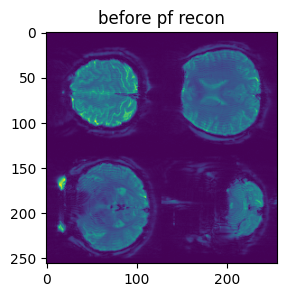

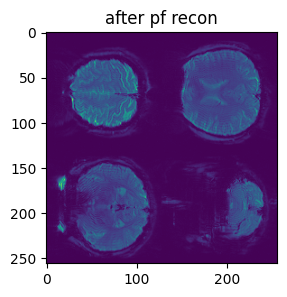

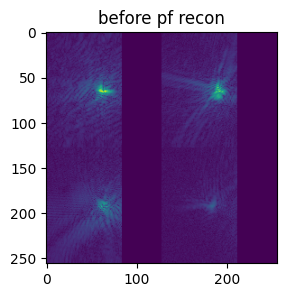

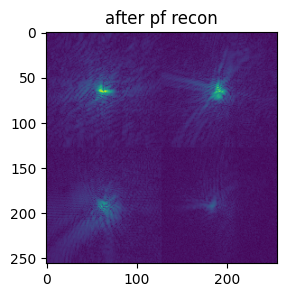

In [14]:
from skimage.util import montage
plt.figure(figsize=(3,3))
plt.imshow(montage(sos(ifft2c(np.moveaxis(kspZpad_kxkyzc[...,10:-10:8,:],-2,0),(1,2)),-1)))
plt.title('before pf recon')
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(montage(sos(ifft2c(np.moveaxis(kspFull_kxkyzc[...,10:-10:8,:],-2,0),(1,2)),-1)))
plt.title('after pf recon')
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(montage(np.sqrt(np.abs(np.moveaxis(kspZpad_kxkyzc[:,:,10:-10:8,0],-1,0)))))
plt.title('before pf recon')
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(montage(np.sqrt(np.abs(np.moveaxis(kspFull_kxkyzc[:,:,10:-10:8,0],-1,0)))))
plt.title('after pf recon')
plt.show()